In [1]:
from qiskit_algorithms import AmplificationProblem
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

## Amplitude amplification
Grover's algorithm uses Hadamard gates to create the uniform superposition of all the states at the beginning of the Grover operator $\mathcal{Q}$. If some information on the good states is available, it might be useful to not start in a uniform superposition but only initialize specific states. This, generalized, version of Grover's algorithm is referred to _Amplitude Amplification_.

To understand _Amplitude Amplificaton_ Let us consider an example with the following marked states: $|010\rangle$ and $|101\rangle$, given below is a quantum circuit `state_preparation` that can prepare the marked states in a superpostion.

More specifically `state_preparation` must be able to prepare the state $|\psi\rangle = \alpha|A\rangle|1\rangle + \beta|B\rangle|0\rangle$, where $|A\rangle$ is the set of all the 'good' or 'marked' states ($|010\rangle$ and $|101\rangle$). Shown below is the circuit that allows to do the same by making use of the multi-qubit control $X$ gate (`mcx` gate).

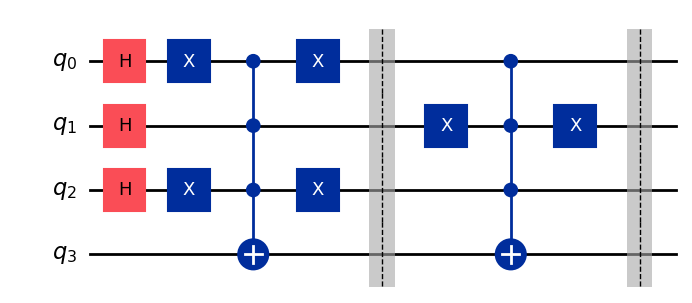

In [2]:
state_preparation = QuantumCircuit(4, name="state preparation")

state_preparation.h([i for i in range(3)])

# Mark |010> -> Apply X gate on qubit 1 because it should be |0>
state_preparation.x([0, 2])  # Apply X to flip |0> to |1> where needed

state_preparation.mcx([0, 1, 2], 3)  # Apply MCX gate

state_preparation.x([0, 2])

state_preparation.barrier()

# Mark |101> -> Apply X gate on qubit 1 because it should be |0>
state_preparation.x(1) # Apply X to flip |0> to |1> where needed

state_preparation.mcx([0, 1, 2], 3)  # Apply MCX gate

state_preparation.x(1)
state_preparation.barrier()

state_preparation.draw('mpl')

As seen in the final statevector output of the circuit, all the 'marked' states have a $|1\rangle$ as their first qubit. (Note that because of Qiskit's little endian notation, the $|1\rangle$ appears on the first qubit rather than the last.)

In [3]:
state = Statevector.from_instruction(state_preparation)
state.draw(output='latex')

<IPython.core.display.Latex object>

The next step is to then design a circuit `oracle` that applies a phase flip if the state is 'marked' and leave a state untouched if it is not 'marked' (This is similar to the oracle in Grover's search).

$$
    \text{oracle}|x\rangle \mapsto \begin{cases} -|x\rangle, &x \text{  is marked} \\ |x\rangle, &x \text{  is not marked}\end{cases}
$$

This can be achieved by using the `CCZ` gate as shown below

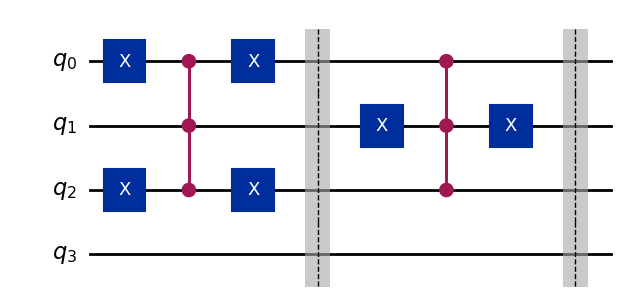

In [4]:
# Step 1: Define an oracle that marks the states |010> and |101> as good states
oracle = QuantumCircuit(4, name="Oracle")

# Mark |001> -> Apply X gates on qubits that should be 0 in the state
oracle.x([0, 2])  # Apply X to flip |0> to |1> where needed

oracle.ccz(0, 2, 1)  # Apply CCZ gate

oracle.x([0, 2])

oracle.barrier()

# Mark |101> -> Apply X gate on qubit 1 because it should be |0>
oracle.x(1) # Apply X to flip |0> to |1> where needed

oracle.ccz(0, 1, 2)  # Apply CCZ gate

oracle.x(1)
oracle.barrier()

oracle.draw("mpl")

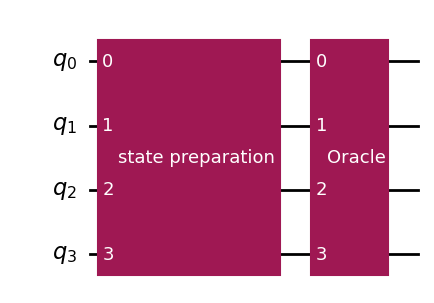

In [5]:
circuit = QuantumCircuit(4)
circuit.append(state_preparation, [i for i in range(4)])
circuit.append(oracle, [i for i in range(4)])
circuit.draw("mpl")

We can see that the `oracle` acting on our initialized state (performed by `state_preparation`) applies a phase flip to the 'marked' states as shown in the statevector represention below.

In [6]:
state = Statevector.from_instruction(circuit)
state.draw(output='latex')

<IPython.core.display.Latex object>

The main difference in the _Amplitude Amplification_ algorithm and the Grover's algorithm comes in the final reflection about the initial state (from `state_preparation`). Qiskit's function `AmplificationProblem` provides a way to perform a reflection about the initial state prepared by `state_preparation` rather than a simple reflection about the full superposition state used in _Grover's search_.

To continue we must pass `oracle` (the operation used to apply phase flip to the 'marked' states), `state_preparation` (The circuit that can initialize our starting state), `is_good_state` (list of 'marked' states) and the `objective_qubits` (List of qubit indices that actually matter to us) to the `AmplificationProblem` as shown below

In [7]:
# we only care about the first two bits being in state 1, thus add both possibilities for the last qubit
problem = AmplificationProblem(
    oracle, state_preparation=state_preparation, is_good_state=["010", "101"], objective_qubits=[0, 1, 2]
)

The set of gates seen after the second barrier in the circuit image below is the optimal set of gates to perform the final reflection about our initial state. We can also manually construct this reflection circuit by utilizing the `state_preparation` circuit. Take `state_preparation` to be $U$ operator. The reflection circuit is then simply constructing $U \mathcal{Q} U^{\dagger}$, where $\mathcal{Q}$ is the usual reflection operator used in Grover's search. This $U \mathcal{Q} U^{\dagger}$ is the same operator used by `AmplificationProblem` as seen after the second barrier in the below circuit.

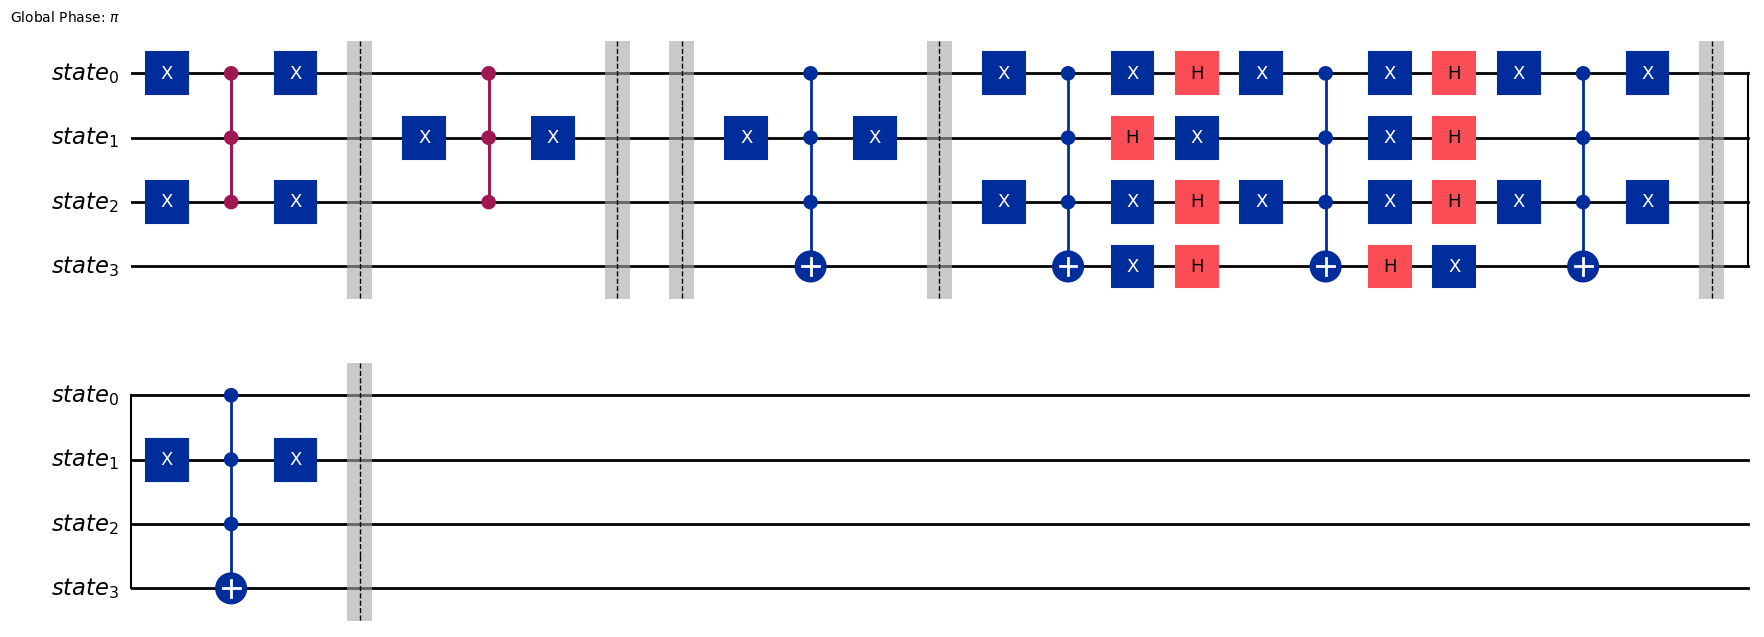

In [8]:
grover_op = problem.grover_operator
grover_op.decompose().draw("mpl")

Putting it all together we now have the final Amplitude Amplificatin problem. The final statevector is shown below and it is clear that only the marked state $|A\rangle|1\rangle$ is left. (of course its in the reverse order because of the little endian notation.)

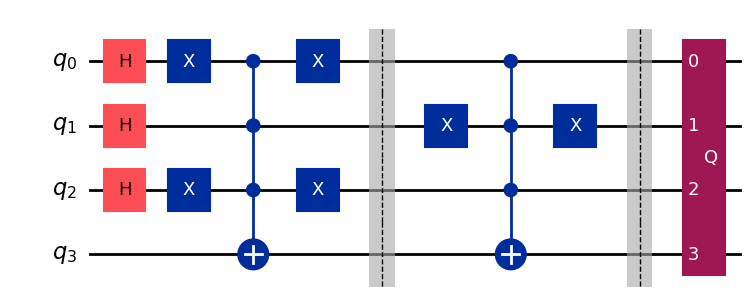

In [9]:
qc = QuantumCircuit(4)

qc.append(state_preparation, [i for i in range(4)])

qc.append(grover_op, [i for i in range(4)])

# qc.measure_all()
qc.decompose().draw("mpl")

In [10]:
state = Statevector.from_instruction(qc)
state.draw(output='latex')

<IPython.core.display.Latex object>